# Datasets

Download from here: https://physionet.org/content/challenge-2021/1.0.3/#files-panel  

To download only the required data use:  
[download.py](../src/preprocessing/download.py)  
or  
`wget -r -N -c -np -A '*' -R 'index.html*' --cut-dirs=3 -nH https://physionet.org/files/challenge-2021/1.0.3/training/`

In [1]:
from collections import defaultdict
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from tqdm import tqdm
import seaborn as sns

from scaling.datasets import PhysioNet
from scaling.augmentations import BasicECGAugmentation

def plt_ecg(*ecgs, w=None, h=None, axs=None):
    leads, length = ecgs[0].shape

    w = 6 if w is None else w
    h = leads // 2 if h is None else h

    fig = None
    if axs is None:
        fig, axs = plt.subplots(leads, 1, sharex=True)
        fig.set_size_inches(w=w, h=h)
    else:
        assert len(axs) == 12, "Need 12 rows in axs for all leads."

    for ecg in ecgs:
        for i, ax in enumerate(axs):
            ax.plot(ecg[i])
    
    return fig, axs

ROOT = Path("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt")
dataset = PhysioNet(ROOT / "metadata_v4.csv")

## ECG data & Augmentation

In [2]:
transform = BasicECGAugmentation(
    crop_size=3000,
    max_warp=0.2,
    min_scale=0.5,
    max_scale=2.0,
    noise_std=0.01,
    max_amplitude=1.0,
    frequency_range=(0.5, 2.0),
    max_mask_duration=50,
    mask_prob=0.33
    )

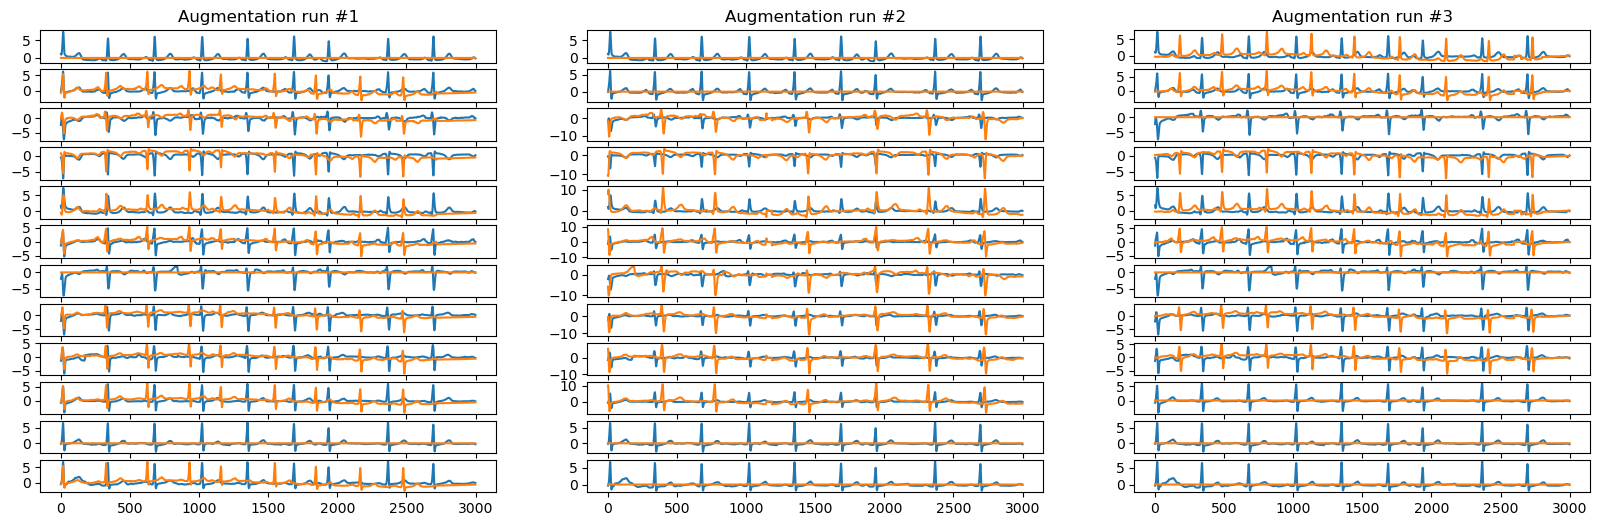

In [3]:
ecg, _ = dataset[1]

fig, axs = plt.subplots(12, 3, sharex=True)
fig.set_size_inches(w=20, h=6)
for i in range(3):
    axs[0, i].set_title(f"Augmentation run #{i + 1}")
    plt_ecg(ecg[:, :3000], transform(ecg), axs=axs[:, i]);
plt.show()

In [4]:
print(ecg.dtype)

torch.float32


## Labels & stratification

In [135]:
# Multi-label stratification. Check out: http://scikit.ml/stratification.html
from skmultilearn.model_selection import IterativeStratification

In [6]:
# Stack all labels in out dataset
y = torch.stack([dataset.get_label(sample) for _, sample in tqdm(dataset.meta.iterrows(), total=len(dataset))])

100%|██████████| 88244/88244 [00:22<00:00, 3872.41it/s]


In [49]:
# We also want to stratify by all datasets. Ensuring that in the test data the same amount of samples comes from every dataset.
dataset_label = pd.get_dummies(df.original_filepath.apply(lambda x: Path(x).parents[1].name)).astype(int).to_numpy()
y_dataset = np.concat([y, dataset_label], axis=1)

In [94]:
# Split into 4 folds.
# Fold 1-3 will be used for 3-fold CV. Fold 4 is our test fold.

k_fold = IterativeStratification(n_splits=4, order=3, sample_distribution_per_fold=[0.3, 0.3, 0.3, 0.1])
folds = list(k_fold.split(dataset.meta, y_dataset))

In [138]:
train_ratios = []
test_ratios = []

# Calculate ratios for each fold
for fold, (train, test) in enumerate(folds):
    y_train, y_test = y[train], y[test]
    
    y_test_ratio = 100 * y_test.sum(axis=0) / y_test.sum()
    y_train_ratio = 100 * y_train.sum(axis=0) / y_train.sum()

    train_ratios.append(y_train_ratio.tolist())
    test_ratios.append(y_test_ratio.tolist())

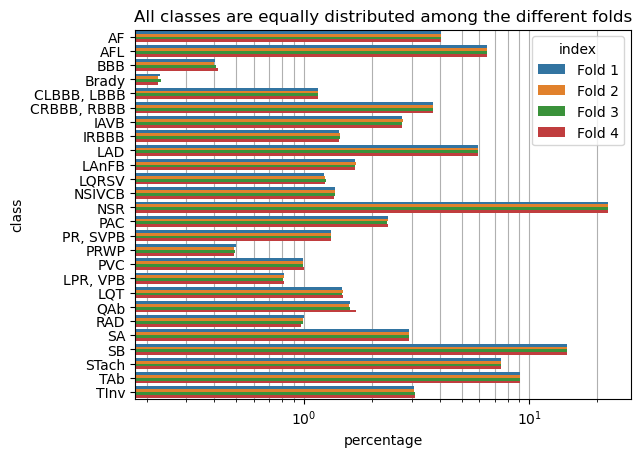

In [139]:
# Prepare data for plotting
fold_labels = [f"Fold {i+1}" for i in range(len(folds))]
class_labels = [dataset.index_to_label(i) for i in range(y.shape[1])]

train_data = pd.DataFrame(train_ratios, columns=class_labels, index=fold_labels).reset_index()
train_data['split'] = 'Train'

test_data = pd.DataFrame(test_ratios, columns=class_labels, index=fold_labels).reset_index()
test_data['split'] = 'Test'

plot_data = pd.concat([train_data, test_data])
plot_data = plot_data.melt(id_vars=['index', 'split'], var_name='class', value_name='percentage')

plt.title("All classes are equally distributed among the different folds")
sns.barplot(data=plot_data[plot_data.split == "Test"], y="class", x="percentage", hue="index", zorder=2)
plt.xscale("log")
plt.grid(axis="x", which="both", zorder=1)
plt.show()

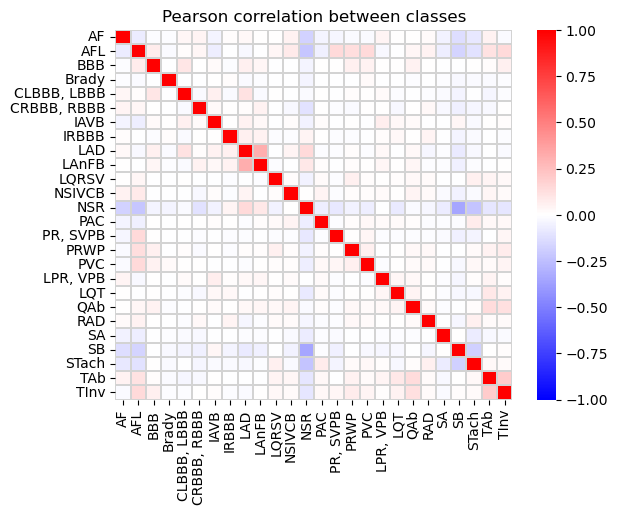

In [213]:
plt.title("Pearson correlation between classes")
corr = pd.DataFrame(torch.corrcoef(y.T), columns=class_labels, index=class_labels)
sns.heatmap(corr, cmap="bwr", vmin=-1, vmax=1, linewidths=0.01, linecolor="lightgray", yticklabels=class_labels)
plt.show()

In [196]:
from sklearn.metrics import mutual_info_score

num_classes = y.shape[1]
pairwise_mi = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        pairwise_mi[i, j] = mutual_info_score(y[:, i], y[:, j])

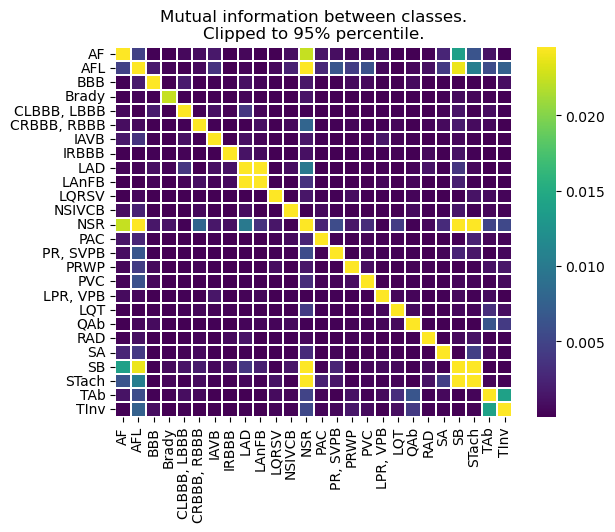

In [212]:
plt.title("Mutual information between classes.\nClipped to 95% percentile.")
corr = pd.DataFrame(pairwise_mi.clip(0, np.percentile(pairwise_mi, 95)), columns=class_labels, index=class_labels)
sns.heatmap(corr, cmap="viridis", linewidths=0.01, linecolor="white", yticklabels=class_labels)
plt.show()

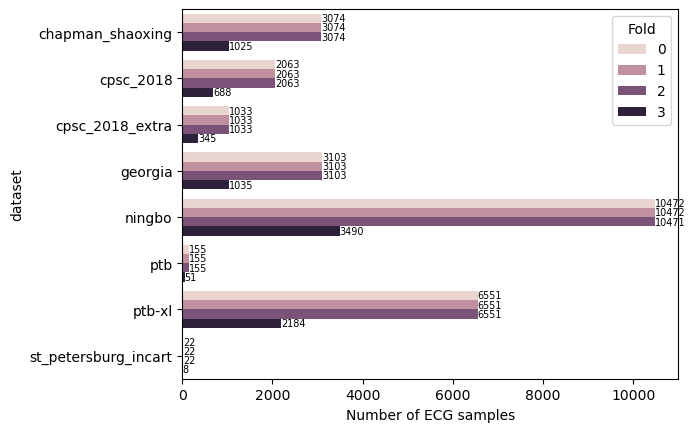

In [110]:
df = dataset.meta.copy()
df = df.reset_index()
df["Fold"] = -1

for i, (_, test) in enumerate(folds):
    df.loc[test, "Fold"] = i

df["dataset"] = df.original_filepath.apply(lambda x: Path(x).parents[1].name)
fold_per_dataset = df.groupby(["Fold", "dataset"], as_index=False).count()

df.Fold = df.Fold.astype("category")

ax = sns.barplot(data=fold_per_dataset, x="index", y="dataset", hue="Fold")
plt.xlabel("Number of ECG samples")
for i in range(4):
    ax.bar_label(ax.containers[i], fontsize=7);
plt.show()

In [134]:
# Save the fold setting!

dataset.meta["Fold"] = -1
dataset.meta = dataset.meta.reset_index()

for i, (_, test) in enumerate(folds):
    dataset.meta.loc[test, "Fold"] = i
dataset.meta.to_csv(ROOT / "metadata_v5.csv")

## Meta data

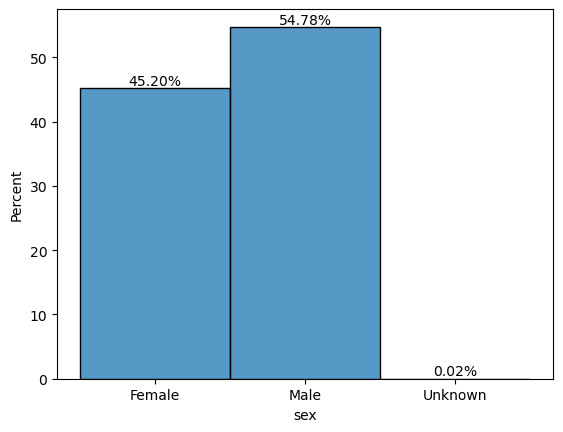

In [12]:
ax = sns.histplot(data=dataset.meta, x="sex", stat="percent")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.show()

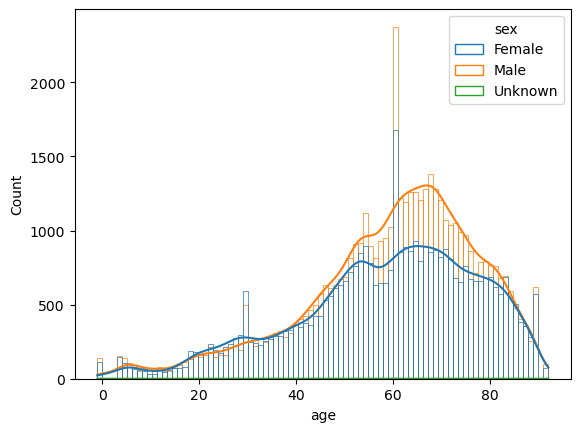

In [13]:
# Some patients have age set to 300. We set this to NaN.
dataset.meta.loc[dataset.meta.age == 300, "age"] = np.nan

sns.histplot(data=dataset.meta, x="age", hue="sex", kde=True, kde_kws=dict(cut=0), fill=False)
plt.show()

Text(0.5, 0, 'ECG Length after resampling')

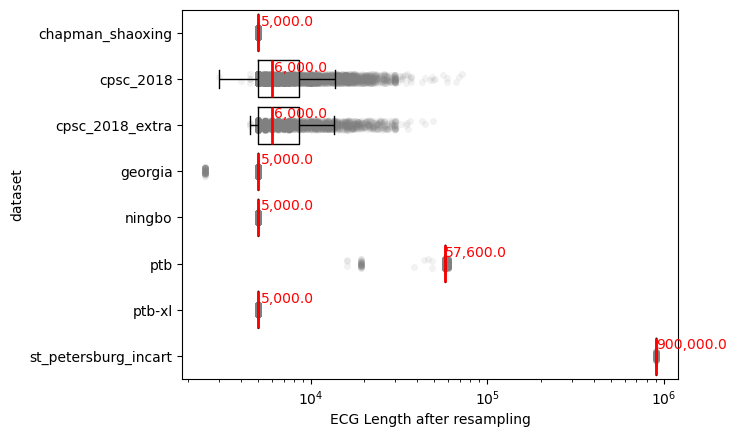

In [14]:
dataset_df = dataset.meta.copy()
dataset_df["dataset"] = dataset_df.original_filepath.apply(lambda x: Path(x).parents[1].name)
medians = dataset_df.groupby("dataset")["new_length"].median()

sns.boxplot(
    data=dataset_df,
    y="dataset",
    x="new_length",
    fill=False,
    color="black",
    fliersize=0,
    zorder=2,
    linewidth=1,
    medianprops={"color": "r", "linewidth": 2},
    order=list(medians.index),
)
sns.stripplot(
    data=dataset_df,
    y="dataset",
    x="new_length",
    alpha=0.1,
    zorder=1,
    linewidth=0,
    color="gray",
    order=list(medians.index),
)

# Calculate and annotate the median
for index, value in enumerate(medians):
    plt.text(
        value + 200,
        index - 0.25,
        f"{value:,}",
        color="red",
        va="center",
        ha="left",
        fontsize=10,
    )

plt.xscale("log")
plt.xlabel("ECG Length after resampling")

Text(0.5, 0, 'ECG Length before resampling')

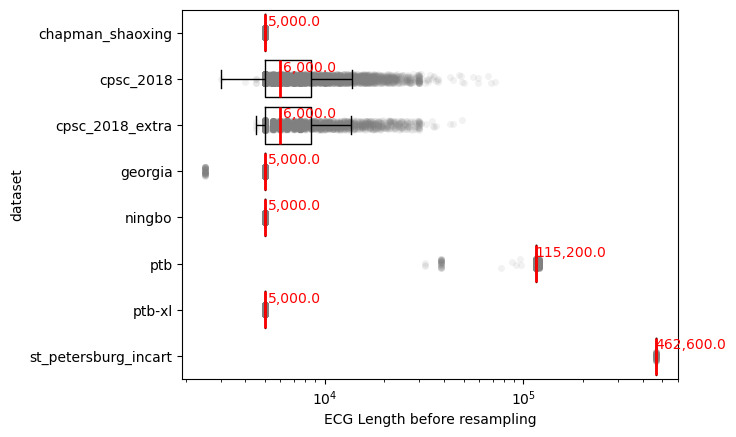

In [15]:
medians = dataset_df.groupby("dataset")["length"].median()

sns.boxplot(
    data=dataset_df,
    y="dataset",
    x="length",
    fill=False,
    color="black",
    fliersize=0,
    zorder=2,
    linewidth=1,
    medianprops={"color": "r", "linewidth": 2},
    order=list(medians.index),
)
sns.stripplot(
    data=dataset_df,
    y="dataset",
    x="length",
    alpha=0.1,
    zorder=1,
    linewidth=0,
    color="gray",
    order=list(medians.index),
)

# Calculate and annotate the median
for index, value in enumerate(medians):
    plt.text(
        value + 200,
        index - 0.25,
        f"{value:,}",
        color="red",
        va="center",
        ha="left",
        fontsize=10,
    )

plt.xscale("log")
plt.xlabel("ECG Length before resampling")